# Machine Learning Approach

In [1]:
# Local libraries
import Tools.ratings_utils as ru
import Tools.system_utils as sys

# Third party packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb


YEAR = 2025
FILENAME = f"Data/Seasons/data_{YEAR}.json"
TOURNAMENT_FILENAME = f"Data/Tournaments/tournament_{YEAR}.csv"
PICKS_FILENAME = f"Data/Tournament Picks/picks_{YEAR}.csv"
RATINGS_FILENAME = f"Data/Season Ratings/data_{YEAR}.json"


# Create data frame for valid teams in the current season that can be used for tournament simulation
score_df = ru.set_rating_data_frame(filename=FILENAME)
rating_score_df = None

/Users/derekfromtexas/anaconda3/envs/college-hoops/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Multiple Seasons

In [36]:
import pandas as pd

YEARS = [2021, 2022, 2023, 2024, 2025]


for YEAR in YEARS:
    FILENAME = f"Data/Seasons/data_{YEAR}.json"
    TOURNAMENT_FILENAME = f"Data/Tournaments/tournament_{YEAR}.csv"
    PICKS_FILENAME = f"Data/Tournament Picks/picks_{YEAR}.csv"
    
    if YEAR is YEARS[0]:
        # Create data frame for valid teams in the current season that can be used for tournament simulation
        score_df = ru.set_rating_data_frame(filename=FILENAME)
    else:
        # Concatenate
        new_season_score_df = ru.set_rating_data_frame(filename=FILENAME)
        score_df = pd.concat([score_df, new_season_score_df], ignore_index=True)


TOURNAMENT_YEAR = YEARS[-1]
FILENAME_YEARS = f"{YEARS[0]}-{TOURNAMENT_YEAR}"
PICKS_FILENAME = f"Data/Tournament Picks/picks_{FILENAME_YEARS}.csv"
RATINGS_FILENAME = f"Data/Season Ratings/data_{FILENAME_YEARS}.json"
    

# Save Ratings to JSON
### (Skip if already run for this season)

In [37]:
rating_score_df = ru.add_ratings_per_game(score_df=score_df)

KeyboardInterrupt: 

In [ ]:
rating_score_df.to_json(RATINGS_FILENAME, orient='records', indent=4)

# Logistic Regression Model - Option #1
### Home team is winner -> 1
### Away team is winner -> 0

In [23]:
# Read data from JSON
rating_score_df = pd.read_json(RATINGS_FILENAME)

# Set data frame and target variable
df = rating_score_df.copy()
df["y"] = (df["Winner"] == df["Home"]).astype(int)

# Add feature columns
df["Massey_diff"] = df["Home_Massey"] - df["Away_Massey"]
df["Colley_diff"] = df["Home_Colley"] - df["Away_Colley"]
df["Elo_diff"] = df["Home_Elo"] - df["Away_Elo"]
df["Adj_Elo_diff"] = df["Home_Adj_Elo"] - df["Away_Adj_Elo"]

In [24]:
# Set features
features = [
    "Massey_diff",
    "Colley_diff",
    "Elo_diff",
    "Adj_Elo_diff"
]

# Create X, y data frames
X = df[features]
y = df["y"]

# Split train/test data sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [26]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.75195550147749
ROC AUC: 0.7683586122400662


In [27]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
})
print(coef_df)

        Feature  Coefficient
0   Massey_diff     0.024211
1   Colley_diff    -0.000084
2      Elo_diff     0.001178
3  Adj_Elo_diff     0.002946


# Test Logistic Regression Model Against March Madness Tournament

In [28]:
ratings_dict = ru.compile_ratings_dict(score_df=score_df)

_, _, tourney_dict = ru.simulate_tournament_with_all_ratings(filename=TOURNAMENT_FILENAME,
                                                             ratings=ratings_dict,
                                                             model=model)
sys.write_tournament_to_csv(tourney_dict=tourney_dict,
                            filename=PICKS_FILENAME,
                            rating_type="log_model")

Round: 1 / Round of 64 - Correct picks: 25 out of 32 - Total Points: 250 out of 320
Round: 2 / Round of 32 - Correct picks: 11 out of 16 - Total Points: 220 out of 320
Round: 3 / Sweet 16 - Correct picks: 7 out of 8 - Total Points: 280 out of 320
Round: 4 / Elite 8 - Correct picks: 4 out of 4 - Total Points: 320 out of 320
Round: 5 / Final 4 - Correct picks: 1 out of 2 - Total Points: 160 out of 320
Round: 6 / Championship - Correct picks: 0 out of 1 - Total Points: 0 out of 320

Total correct picks in tournament: 48 out of 63

Total points in tournament: 1230 out of 1920

CSV written to Data/Tournament Picks/picks_2025_log_model.csv


# XGBoost Model - Option #2

In [29]:
# Read data from JSON
rating_score_df = pd.read_json(RATINGS_FILENAME)

# Set data frame and target variable
df = rating_score_df.copy()
df["y"] = (df["Winner"] == df["Home"]).astype(int)

# Add feature columns
df["Massey_diff"] = df["Home_Massey"] - df["Away_Massey"]
df["Colley_diff"] = df["Home_Colley"] - df["Away_Colley"]
df["Elo_diff"] = df["Home_Elo"] - df["Away_Elo"]
df["Adj_Elo_diff"] = df["Home_Adj_Elo"] - df["Away_Adj_Elo"]

In [30]:
# Set features
features = [
    "Massey_diff",
    "Colley_diff",
    "Elo_diff",
    "Adj_Elo_diff"
]

# Create X, y data frames
X = df[features]
y = df["y"]

# Split train/test data sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Train XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    use_label_encoder=False
)

model.fit(X_train, y_train)

/Users/derekfromtexas/anaconda3/envs/college-hoops/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:51:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [32]:
# Evaluate
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [33]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.7500434555883887
ROC AUC: 0.7636848403243343


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

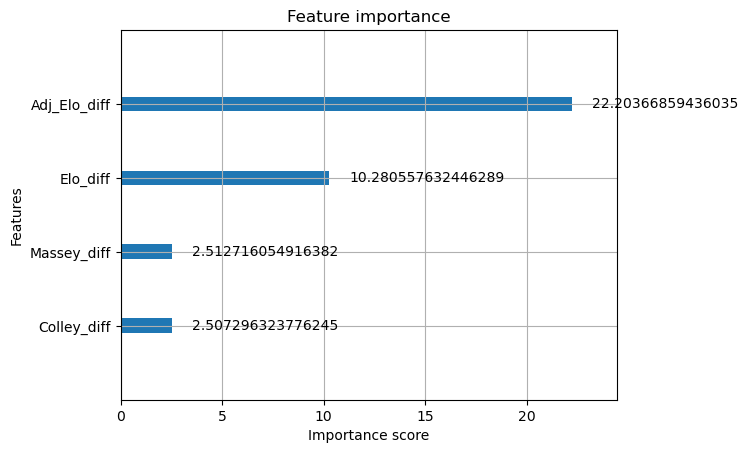

In [34]:
xgb.plot_importance(model, importance_type="gain")

# Test XGBoost Model Against March Madness Tournament

In [35]:
ratings_dict = ru.compile_ratings_dict(score_df=score_df)

_, _, tourney_dict = ru.simulate_tournament_with_all_ratings(filename=TOURNAMENT_FILENAME,
                                                             ratings=ratings_dict,
                                                             model=model)
sys.write_tournament_to_csv(tourney_dict=tourney_dict,
                            filename=PICKS_FILENAME,
                            rating_type="xgb_model")

Round: 1 / Round of 64 - Correct picks: 25 out of 32 - Total Points: 250 out of 320
Round: 2 / Round of 32 - Correct picks: 12 out of 16 - Total Points: 240 out of 320
Round: 3 / Sweet 16 - Correct picks: 7 out of 8 - Total Points: 280 out of 320
Round: 4 / Elite 8 - Correct picks: 3 out of 4 - Total Points: 240 out of 320
Round: 5 / Final 4 - Correct picks: 1 out of 2 - Total Points: 160 out of 320
Round: 6 / Championship - Correct picks: 1 out of 1 - Total Points: 320 out of 320

Total correct picks in tournament: 49 out of 63

Total points in tournament: 1490 out of 1920

CSV written to Data/Tournament Picks/picks_2025_xgb_model.csv
